In [14]:
# try:
#     import zarr
# except: 
#     !cp -r '/kaggle/input/shuo-czii-cryo-et/wheel_files' '/kaggle/working/'
#     !cp -r '/kaggle/input/shuo-czii-cryo-et/models' '/kaggle/working/'
#     !pip install /kaggle/working/wheel_files/monai-1.4.0-py3-none-any.whl
#     !pip install /kaggle/working/wheel_files/yacs-0.1.8-py3-none-any.whl
#     !pip install /kaggle/working/wheel_files/asciitree-0.3.3/asciitree-0.3.3
#     !pip install --no-index --find-links=/kaggle/working/wheel_files zarr
#     !pip install --no-index --find-links=/kaggle/working/wheel_files connected-components-3d

# print('PIP INSTALL OK!!!')

In [15]:
import os
import copy
import glob
import json
import threading
from typing import List, Tuple

import cc3d
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import zarr
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    NormalizeIntensityd,
    Orientationd,
)

from models import create_model

In [16]:
lock = threading.Lock()

PARTICLE= [
    {
        "name": "apo-ferritin",
        "difficulty": 'easy',
        "pdb_id": "4V1W",
        "label": 1,
        "color": [0, 255, 0, 0],
        "radius": 60,
        "map_threshold": 0.0418
    },
    {
        "name": "beta-amylase",
        "difficulty": 'ignore',
        "pdb_id": "1FA2",
        "label": 2,
        "color": [0, 0, 255, 255],
        "radius": 65,
        "map_threshold": 0.035
    },
    {
        "name": "beta-galactosidase",
        "difficulty": 'hard',
        "pdb_id": "6X1Q",
        "label": 3,
        "color": [0, 255, 0, 255],
        "radius": 90,
        "map_threshold": 0.0578
    },
    {
        "name": "ribosome",
        "difficulty": 'easy',
        "pdb_id": "6EK0",
        "label": 4,
        "color": [0, 0, 255, 0],
        "radius": 150,
        "map_threshold": 0.0374
    },
    {
        "name": "thyroglobulin",
        "difficulty": 'hard',
        "pdb_id": "6SCJ",
        "label": 5,
        "color": [0, 255, 255, 0],
        "radius": 130,
        "map_threshold": 0.0278
    },
    {
        "name": "virus-like-particle",
        "difficulty": 'easy',
        "pdb_id": "6N4V",
        "label": 6,
        "color": [0, 0, 0, 255],
        "radius": 135,
        "map_threshold": 0.201
    }
]

PARTICLE_NAME = [
    PARTICLE[i]['name'] for i in range(6)
]

In [ ]:
DATA_KAGGLE_DIR = '"path-of-your-czii-cryo-et-object-identification'

MODE='local'

if MODE == 'local':
    valid_dir = f'{DATA_KAGGLE_DIR}/train'
    # valid_id = ['TS_5_4']
    # valid_id = ['TS_6_4']
    # valid_id = ['TS_69_2']
    # valid_id = ['TS_6_6']
    # valid_id = ['TS_86_3']
    # valid_id = ['TS_73_6']
    # valid_id = ['TS_99_9']
    valid_id = ['TS_5_4', 'TS_6_4', 'TS_69_2']
    # valid_id = ['TS_5_4', 'TS_6_4', 'TS_69_2', 'TS_6_6', 'TS_86_3', 'TS_73_6']

if MODE == 'submit':
    valid_dir = f'{DATA_KAGGLE_DIR}/test'
    valid_id = glob.glob(f'{valid_dir}/static/ExperimentRuns/*')
    valid_id = [f.split('/')[-1] for f in valid_id]
    
valid_ids = copy.deepcopy(valid_id)

In [ ]:
best_weights_root = "path-of-your-best-ckpts"

model_configs = [
    {
        "model_name": "monai_unet",
        "spatial_dims": 3,
        "in_channels": 1,
        "out_channels": 7,
        "channels": [48, 64, 80, 80],
        "strides": [2, 2, 1],
        "num_res_units": 1,
    },
    {
        "model_name": "monai_unet",
        "spatial_dims": 3,
        "in_channels": 1,
        "out_channels": 7,
        "channels": [48, 64, 80, 80],
        "strides": [2, 2, 1],
        "num_res_units": 2,
    },
    {
        "model_name": "monai_unet",
        "spatial_dims": 3,
        "in_channels": 1,
        "out_channels": 6,
        "channels": [48, 64, 80, 80],
        "strides": [2, 2, 1],
        "num_res_units": 1,
    },
    {"model_name": "densevnet", "in_channels": 1, "out_channels": 7},
    {"model_name": "voxresnet", "in_channels": 1, "out_channels": 7},
    {"model_name": "voxhrnet", "in_channels": 1, "out_channels": 7},
    {
        "model_name": "segresnet",
        "in_channels": 1,
        "out_channels": 6,
        "upsample_mode": "deconv",
    },
    {
        "model_name": "unet2e3d",
        "in_channels": 3,
        "out_channels": 6,
        "decoder_dim": [80, 80, 64, 32, 16],
    },
]

best_model_ckpts = [
    "epoch122-step2952-valid_loss0.3625-val_metric0.8367.ckpt",
    "epoch148-step3576-valid_loss1.1154-val_metric0.7722.ckpt",
    "epoch153-step3696-valid_loss0.3021-val_metric0.8900.ckpt",
    "epoch194-step4680-valid_loss1.0213-val_metric0.8788.ckpt",
    "epoch138-step3336-valid_loss0.3690-val_metric0.8476.ckpt",
    "epoch152-step3672-valid_loss0.4333-val_metric0.7929.ckpt",
    "epoch195-step4704-valid_loss0.4258-val_metric0.7914.ckpt",
    "epoch188-step4536-valid_loss0.4231-val_metric0.8659.ckpt",
    "epoch198-step4776-valid_loss0.3471-val_metric0.8730.ckpt",
    "epoch133-val_loss0.52-val_metric0.56-step3216.ckpt",
    "epoch314-val_loss0.54-val_metric0.54-step7560.ckpt",
    "epoch114-val_loss0.55-val_metric0.53-step2760.ckpt",
]

best_model_configs = [
    model_configs[0],
    model_configs[0],
    model_configs[1],
    model_configs[0],
    model_configs[0],
    model_configs[3],
    model_configs[4],
    model_configs[5],
    model_configs[5],
    model_configs[2],
    model_configs[6],
    model_configs[7],
]

# ensemble settings
ensemble_model_indices = [0, 1, 2, 3, 6, 7, 11]
certainty_threshold = 0.15
edge_weight = 0.1
patch_sizes_list = [[128, 384, 384] for _ in best_model_configs]
overlap_sizes = [32, 32, 32]
tomo_threshold = [2, 2, 2, 5, 5, 5]
classes = [1, 2, 3, 4, 5, 6]

In [19]:
def load_modified_state_dict(
    model,
    checkpoint_path,
    current_prefix="model.model.",
    replaced_prefix='model.',
    ignore_keys=("loss_fn",),
):

    # Load checkpoint
    ckpt = torch.load(checkpoint_path, map_location='cpu')

    # Retrieve state_dict (handle different checkpoint structures)
    state_dict = ckpt.get("state_dict", ckpt)

    # Process key names
    new_state_dict = {}
    for key in state_dict.keys():
        # Remove the specified prefix if it exists
        new_key = (
            key.replace(current_prefix, replaced_prefix, 1)
            if key.startswith(current_prefix)
            else key
        )

        # Skip keys that should be ignored
        if not any(new_key.startswith(ignore) for ignore in ignore_keys):
            new_state_dict[new_key] = state_dict[key]

    # Load parameters
    verbose = model.load_state_dict(new_state_dict, strict=False)

    print(f"loading checkpoint '{checkpoint_path}' ", verbose)
    return model

In [20]:
model_list = []
for idx, (net_cfg, ckpt_name) in enumerate(zip(best_model_configs, best_model_ckpts)):
    if idx in ensemble_model_indices:
        net_ckpt_path = os.path.join(best_weights_root, ckpt_name)
        model_name = net_cfg["model_name"]
        params = {key: value for key, value in net_cfg.items() if key != 'model_name'}
        model = create_model(model_name, **params)
        if model_name in ['monai_unet', 'voxhrnet']:
            current_prefix = "model.model."
            replaced_prefix='model.'
        elif model_name in ['densevnet', 'voxresnet', 'segresnet', 'unet2e3d']:
            current_prefix = "model."
            replaced_prefix=''
        
        load_modified_state_dict(
            model, net_ckpt_path, 
            current_prefix,
            replaced_prefix
        )
        
        model = model.to("cpu").eval().half()
        model_list.append(model)

loading checkpoint '/data/gavin/Kaggle-2024-CZII-Pub/input/czii2024-best-ckpts/epoch122-step2952-valid_loss0.3625-val_metric0.8367.ckpt'  <All keys matched successfully>
loading checkpoint '/data/gavin/Kaggle-2024-CZII-Pub/input/czii2024-best-ckpts/epoch148-step3576-valid_loss1.1154-val_metric0.7722.ckpt'  <All keys matched successfully>
loading checkpoint '/data/gavin/Kaggle-2024-CZII-Pub/input/czii2024-best-ckpts/epoch153-step3696-valid_loss0.3021-val_metric0.8900.ckpt'  <All keys matched successfully>
loading checkpoint '/data/gavin/Kaggle-2024-CZII-Pub/input/czii2024-best-ckpts/epoch194-step4680-valid_loss1.0213-val_metric0.8788.ckpt'  <All keys matched successfully>
loading checkpoint '/data/gavin/Kaggle-2024-CZII-Pub/input/czii2024-best-ckpts/epoch195-step4704-valid_loss0.4258-val_metric0.7914.ckpt'  <All keys matched successfully>
loading checkpoint '/data/gavin/Kaggle-2024-CZII-Pub/input/czii2024-best-ckpts/epoch188-step4536-valid_loss0.4231-val_metric0.8659.ckpt'  <All keys ma

In [21]:
# Non-random transforms to be cached
inference_transforms = Compose(
    [
        EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        NormalizeIntensityd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
    ]
)

def read_one_data(id, static_dir):
    zarr_dir = f'{static_dir}/{id}/VoxelSpacing10.000'
    zarr_file = f'{zarr_dir}/denoised.zarr'
    zarr_data = zarr.open(zarr_file, mode='r')
    volume = zarr_data[0][:]
    scale = 10
    return volume, scale

def build_weights(patch_sizes, overlap_sizes, edge_weight, device="cuda:0"):
    weights = torch.zeros(*patch_sizes, dtype=torch.half, device=device)
    weights += edge_weight
    weights[
        overlap_sizes[0] // 4 : patch_sizes[0] - overlap_sizes[0] // 4,
        overlap_sizes[1] // 4 : patch_sizes[1] - overlap_sizes[1] // 4,
        overlap_sizes[2] // 4 : patch_sizes[2] - overlap_sizes[2] // 4,
    ] += (
        1 - edge_weight
    )
    return weights


def calculate_patch_starts_with_overlap(
    dimension_size: int, patch_size: int, overlap: int
) -> List[int]:
    if dimension_size <= patch_size:
        return [0]

    num_patches = np.ceil(
        (dimension_size - overlap) / (patch_size - overlap) + 1
    ).astype(int)
    patch_starts = []
    for i in range(num_patches):
        pos = int(i * (patch_size - overlap))
        if pos + patch_size > dimension_size:
            pos = dimension_size - patch_size
        if pos not in patch_starts:
            patch_starts.append(pos)
    return patch_starts


def extract_3d_patches_overlap_wo_data(
    arrays_shape: Tuple[int, int, int],
    patch_sizes: Tuple[int, int, int],
    overlap_sizes: Tuple[int, int, int],
) -> List[Tuple[int, int, int]]:

    patch_starts_x = calculate_patch_starts_with_overlap(
        arrays_shape[0], patch_sizes[0], overlap_sizes[0]
    )
    patch_starts_y = calculate_patch_starts_with_overlap(
        arrays_shape[1], patch_sizes[1], overlap_sizes[1]
    )
    patch_starts_z = calculate_patch_starts_with_overlap(
        arrays_shape[2], patch_sizes[2], overlap_sizes[2]
    )
    patch_size_d, patch_size_h, patch_size_w = patch_sizes
    coordinates = []
    for x in patch_starts_x:
        for y in patch_starts_y:
            for z in patch_starts_z:
                coordinates.append((x, y, z))

    return coordinates


def apply_tta(patch, transform, is_inverse=False):
    transform_map = {
        "t0": lambda x: x,  # No transformation
        "t1": lambda x: (
            torch.rot90(x, k=1, dims=(3, 4))
            if not is_inverse
            else torch.rot90(x, k=-1, dims=(3, 4))
        ),
        "t2": lambda x: (
            torch.rot90(x, k=2, dims=(3, 4))
            if not is_inverse
            else torch.rot90(x, k=-2, dims=(3, 4))
        ),
        "t3": lambda x: (
            torch.rot90(x, k=3, dims=(3, 4))
            if not is_inverse
            else torch.rot90(x, k=-3, dims=(3, 4))
        ),
        "t4": lambda x: (
            torch.flip(x, dims=[2]) if not is_inverse else torch.flip(x, dims=[2])
        ),
        "t5": lambda x: (
            torch.flip(x, dims=[3]) if not is_inverse else torch.flip(x, dims=[3])
        ),
        "t6": lambda x: (
            torch.flip(x, dims=[4]) if not is_inverse else torch.flip(x, dims=[4])
        ),
    }

    # Check if transform is valid, else return the input patch unchanged
    if transform in transform_map:
        return transform_map[transform](patch)
    else:
        raise ValueError(f"Unknown transform: {transform}")

In [22]:

def infer(
    task_id,
    device_id,
    certainty_threshold=0.25,
    edge_weight=0.1,
    submit_df=None,
    model_list=None,
    patch_sizes_list=None,
    overlap_sizes=None,
    tomo_threshold=None,
    probability=None,
    count=None,
):
    with torch.no_grad():
        device = torch.device(f"cuda:{device_id}")
        
        # read tomogram
        volume, scale = read_one_data(task_id, static_dir=f'{valid_dir}/static/ExperimentRuns')

        image = torch.tensor(volume, device=device, dtype=torch.half)

        D, H, W = (184, 630, 630)
        coordinates_list = [
            extract_3d_patches_overlap_wo_data((D, H, W), patch_sizes, overlap_sizes)
            for patch_sizes in patch_sizes_list
        ]
        weights_list = [
            build_weights(patch_sizes, overlap_sizes, edge_weight, device)
            for patch_sizes in patch_sizes_list
        ]

        probability.zero_()
        count.zero_()

        for idx, (model, patch_sizes, coordinates, weights) in enumerate(
            zip(
                model_list,
                patch_sizes_list,
                coordinates_list,
                weights_list,
            )
        ):

            for coor in coordinates:

                # obtain slice
                patch = image[
                    coor[0] : coor[0] + patch_sizes[0],
                    coor[1] : coor[1] + patch_sizes[1],
                    coor[2] : coor[2] + patch_sizes[2],
                ]

                # (B, C, D, H, W)
                normalized_patch = (
                    inference_transforms({"image": patch})["image"]
                    .to(torch.half)
                    .unsqueeze(0)
                )

                probs = []
                for transform in ["t0", "t1", "t2", "t3", "t4", "t5", "t6"]:

                    # tta
                    transformed_patch = apply_tta(normalized_patch, transform)

                    # inference
                    logits = model(transformed_patch)
                    preds = F.softmax(logits, dim=1)

                    # inverse tta
                    probs += [apply_tta(preds, transform, is_inverse=True)[0]]

                probs = torch.stack(probs).mean(0)

                # [1, 3, 4, 5, 6]
                if model.out_channels == 7:
                    slice = [1, 3, 4, 5, 6]
                elif model.out_channels == 6:
                    slice = [1, 2, 3, 4, 5]
                
                probability[
                    :,
                    coor[0] : coor[0] + patch_sizes[0],
                    coor[1] : coor[1] + patch_sizes[1],
                    coor[2] : coor[2] + patch_sizes[2],
                ] += (
                    probs[slice] * weights
                )

                count[
                    coor[0] : coor[0] + patch_sizes[0],
                    coor[1] : coor[1] + patch_sizes[1],
                    coor[2] : coor[2] + patch_sizes[2],
                ] += weights

        probability = probability / count

        probability0 = probability
        probability1 = F.interpolate(
            probability0[1:], scale_factor=0.5, mode="bilinear", align_corners=False
        )
        binary0 = (probability0 > certainty_threshold).data.cpu().numpy()
        binary1 = (probability1 > certainty_threshold).data.cpu().numpy()

        location = [np.empty((0, 3)) for i in range(6)]

        for c in [0, 2, 3, 4, 5]:

            if c == 0:
                componet = cc3d.connected_components(binary0[c])
            else:
                componet = cc3d.connected_components(binary1[c - 2])

            stats = cc3d.statistics(componet)

            if c == 0:
                zyx = stats["centroids"][1:] * 10.012444
            else:
                zyx = stats["centroids"][1:] * 10.012444 * [[1, 2, 2]]

            if tomo_threshold:
                zyx = zyx[stats["voxel_counts"][1:] > tomo_threshold[c]]

            xyz = np.ascontiguousarray(zyx[:, ::-1])
            location[c] = xyz

        print("location", np.concatenate(location).shape)
        for particle in PARTICLE:
            name = particle['name']
            class_id = particle['label'] - 1

            submit_df.append(
                pd.DataFrame(
                    {
                        "experiment": task_id,
                        "particle_type": name,
                        "x": location[class_id][:, 0],
                        "y": location[class_id][:, 1],
                        "z": location[class_id][:, 2],
                    }
                )
            )

In [23]:
def thread_infer(
    task_ids,
    device_id,
    certainty_threshold=0.25,
    edge_weight=0.1,
    submit_df=None,
    model_list=None,
    patch_sizes_list=None,
    overlap_sizes=None,
    tomo_threshold=None,
):
    D, H, W = (184, 630, 630)
    device = torch.device(f"cuda:{device_id}")
    probability = torch.zeros(
        (5, D, H, W), device=device, dtype=torch.half, requires_grad=False
    )
    count = torch.zeros((D, H, W), device=device, dtype=torch.half, requires_grad=False)

    while True:
        with lock:
            if len(task_ids) == 0:
                break
            task_id = task_ids.pop()
        infer(
            task_id,
            device_id,
            certainty_threshold,
            edge_weight,
            submit_df,
            model_list,
            patch_sizes_list,
            overlap_sizes,
            tomo_threshold,
            probability,
            count,
        )

In [24]:
# concurrent running
submit_results = {
    0: [],  1: []
}
models = {
    0: [copy.deepcopy(model).to("cuda:0") for model in model_list],
    1: [copy.deepcopy(model).to("cuda:1") for model in model_list]
}

threads = [
    threading.Thread(
        target=thread_infer,
        args=(
            valid_ids,
            device_id,
            certainty_threshold,
            edge_weight,
            submit_results[device_id],
            models[device_id],
            patch_sizes_list,
            overlap_sizes,
            tomo_threshold,
        )
    )
    for device_id in [0, 1]
]

for thread in threads:
    thread.start()
for thread in threads:
    thread.join()

# merge results and generate submission
submit_df = pd.concat(submit_results[0] + submit_results[1])
submit_df.insert(0, "id", np.arange(len(submit_df)))
submit_df.to_csv("submission.csv", index=False)
submit_df

location (255, 3)
location (313, 3)
location (244, 3)


,id,experiment,particle_type,x,y,z
0,0,TS_69_2,apo-ferritin,466.348834,3676.107324,488.684286
1,1,TS_69_2,apo-ferritin,1343.574628,5871.371328,518.686980
2,2,TS_69_2,apo-ferritin,1185.296679,2724.268219,529.334356
3,3,TS_69_2,apo-ferritin,3465.846000,6171.956551,531.099639
4,4,TS_69_2,apo-ferritin,81.558652,2153.228912,547.917162
...,...,...,...,...,...,...
4,807,TS_6_4,virus-like-particle,5212.238566,5768.010215,875.554205
5,808,TS_6_4,virus-like-particle,5088.806910,4118.807017,992.190594
6,809,TS_6_4,virus-like-particle,111.299619,5622.148797,1060.285521
7,810,TS_6_4,virus-like-particle,1451.105837,4797.124914,1117.069417


In [25]:

import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment


class dotdict(dict):
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    def __getattr__(self, name):
        try:
            return self[name]
        except KeyError:
            raise AttributeError(name)
        
        
def read_one_truth(id, overlay_dir):
    location={}

    json_dir = f'{overlay_dir}/{id}/Picks'
    for p in PARTICLE_NAME:
        json_file = f'{json_dir}/{p}.json'

        with open(json_file, 'r') as f:
            json_data = json.load(f)

        num_point = len(json_data['points'])
        loc = np.array([list(json_data['points'][i]['location'].values()) for i in range(num_point)])
        location[p] = loc

    return location

def do_one_eval(truth, predict, threshold):
    P = len(predict)
    T = len(truth)

    if P == 0:
        hit = [[], []]
        miss = np.arange(T).tolist()
        fp = []
        metric = [P, T, len(hit[0]), len(miss), len(fp)]
        return hit, fp, miss, metric

    if T == 0:
        hit = [[], []]
        fp = np.arange(P).tolist()
        miss = []
        metric = [P, T, len(hit[0]), len(miss), len(fp)]
        return hit, fp, miss, metric

    # ---
    distance = predict.reshape(P, 1, 3) - truth.reshape(1, T, 3)
    distance = distance**2
    distance = distance.sum(axis=2)
    distance = np.sqrt(distance)
    p_index, t_index = linear_sum_assignment(distance)

    valid = distance[p_index, t_index] <= threshold
    p_index = p_index[valid]
    t_index = t_index[valid]
    hit = [p_index.tolist(), t_index.tolist()]
    miss = np.arange(T)
    miss = miss[~np.isin(miss, t_index)].tolist()
    fp = np.arange(P)
    fp = fp[~np.isin(fp, p_index)].tolist()

    metric = [P, T, len(hit[0]), len(miss), len(fp)]  # for lb metric F-beta copmutation
    return hit, fp, miss, metric


def compute_lb(submit_df, overlay_dir):
    valid_id = list(submit_df["experiment"].unique())
    print(valid_id)

    eval_df = []
    for id in valid_id:
        truth = read_one_truth(
            id, overlay_dir
        )  # =f'{valid_dir}/overlay/ExperimentRuns')
        id_df = submit_df[submit_df["experiment"] == id]
        for p in PARTICLE:
            p = dotdict(p)
            print("\r", id, p.name, end="", flush=True)
            xyz_truth = truth[p.name]
            xyz_predict = id_df[id_df["particle_type"] == p.name][
                ["x", "y", "z"]
            ].values

            hit, fp, miss, metric = do_one_eval(xyz_truth, xyz_predict, p.radius * 0.5)
            eval_df.append(
                dotdict(
                    id=id,
                    particle_type=p.name,
                    P=metric[0],
                    T=metric[1],
                    hit=metric[2],
                    miss=metric[3],
                    fp=metric[4],
                )
            )
    print("")
    eval_df = pd.DataFrame(eval_df)
    gb = eval_df.groupby("particle_type").agg("sum").drop(columns=["id"])
    gb.loc[:, "precision"] = gb["hit"] / gb["P"]
    gb.loc[:, "precision"] = gb["precision"].fillna(0)
    gb.loc[:, "recall"] = gb["hit"] / gb["T"]
    gb.loc[:, "recall"] = gb["recall"].fillna(0)
    gb.loc[:, "f-beta4"] = (
        17 * gb["precision"] * gb["recall"] / (16 * gb["precision"] + gb["recall"])
    )
    gb.loc[:, "f-beta4"] = gb["f-beta4"].fillna(0)

    gb = gb.sort_values("particle_type").reset_index(drop=False)
    # https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/544895
    gb.loc[:, "weight"] = [1, 0, 2, 1, 2, 1]
    lb_score = (gb["f-beta4"] * gb["weight"]).sum() / gb["weight"].sum()
    return gb, lb_score

['TS_69_2', 'TS_5_4', 'TS_6_4']
 TS_6_4 virus-like-particlee
lb_score: 0.8578587463520673
         particle_type    P    T  hit  miss   fp  precision    recall   f-beta4  weight
0         apo-ferritin  218  139  133     6   85   0.610092  0.956835  0.925880       1
1         beta-amylase    0   31    0    31    0   0.000000  0.000000  0.000000       0
2   beta-galactosidase   91   40   34     6   57   0.373626  0.850000  0.790698       2
3             ribosome  218  142  132    10   86   0.605505  0.929577  0.901205       1
4        thyroglobulin  256   94   86     8  170   0.335938  0.914894  0.830682       2
5  virus-like-particle   29   30   28     2    1   0.965517  0.933333  0.935167       1



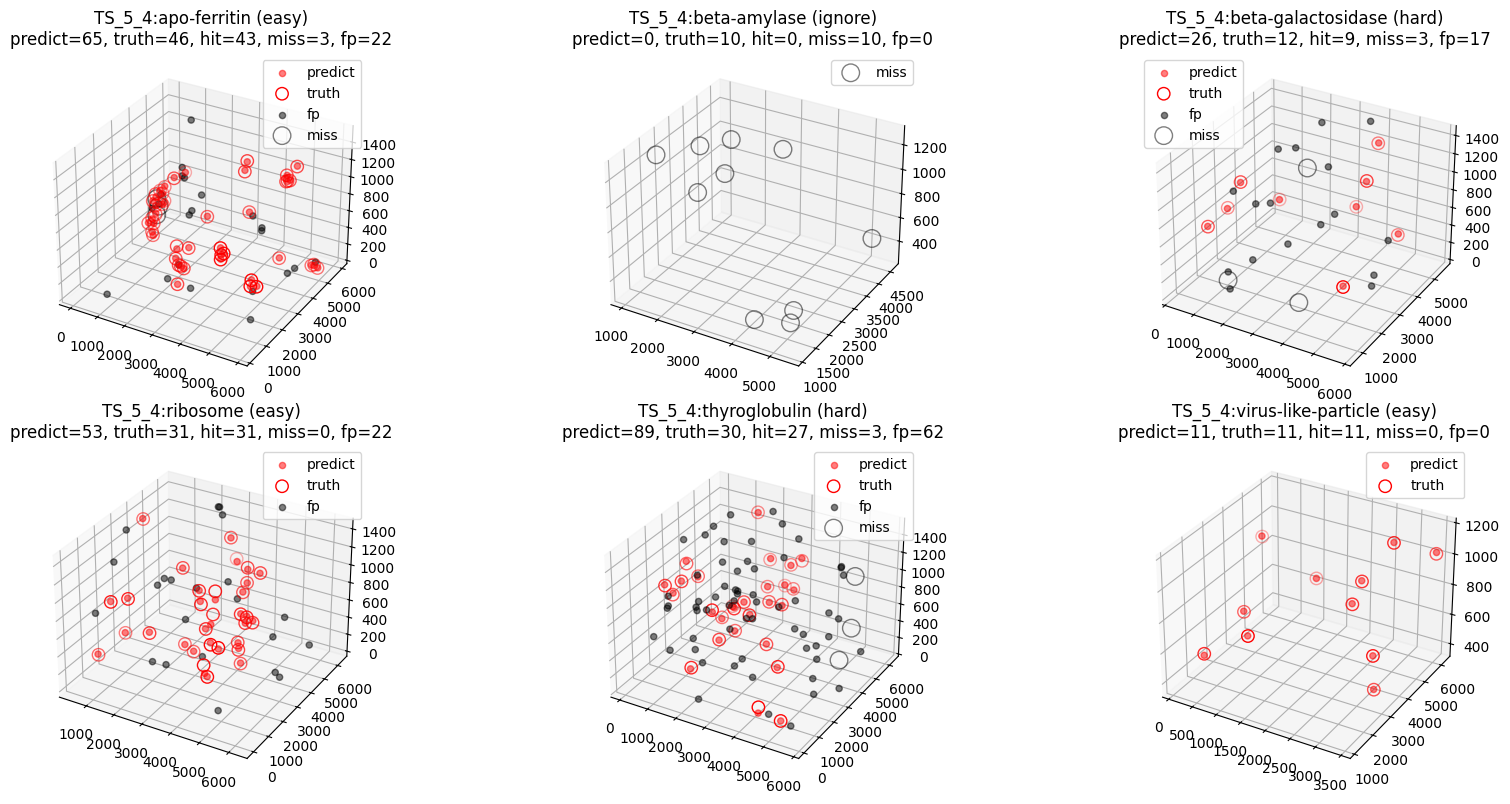

: 

In [ ]:
# visualization
if 1:
    if MODE=='local':
        pd.set_option('display.max_columns', 500)
        pd.set_option('display.width', 1000)
        
        submit_df=pd.read_csv('submission.csv')
        
        gb, lb_score = compute_lb(submit_df, f'{valid_dir}/overlay/ExperimentRuns')
        print('lb_score:',lb_score)
        print(gb)
        print('')

        #--------------------------------------------
        #visualisation

        fig = plt.figure(figsize=(18, 8))

        id = valid_id[0]
        truth = read_one_truth(id, overlay_dir=f'{valid_dir}/overlay/ExperimentRuns')

        submit_df=pd.read_csv('submission.csv')
        submit_df = submit_df[submit_df['experiment']==id]
        for p in PARTICLE:
            p = dotdict(p)
            xyz_truth = truth[p.name]
            xyz_predict = submit_df[submit_df['particle_type']==p.name][['x','y','z']].values
            hit, fp, miss, metric = do_one_eval(xyz_truth, xyz_predict, p.radius)
            ax = fig.add_subplot(2, 3, p.label, projection='3d')

            if 0:
                pt = xyz_predict
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=0.25, color='b', label='predict')
                pt = xyz_truth
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], s=160, alpha=0.25, color='r', label='truth')
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], s=160, facecolors='none', edgecolors='r')
            if 1:
                if hit[0]:
                    pt = xyz_predict[hit[0]]
                    ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=0.5, color='r', label='predict')
                    pt = xyz_truth[hit[1]]
                    ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], s=80, facecolors='none', edgecolors='r', label='truth')
                if fp:
                    pt = xyz_predict[fp]
                    ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=0.5, color='k', label='fp')
                if miss:
                    pt = xyz_truth[miss]
                    ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], s=160, alpha=0.5, facecolors='none', edgecolors='k', label='miss')
            ax.legend()
            ax.set_title(
                f'{id}:{p.name} ({p.difficulty})\npredict={metric[0]}, truth={metric[1]}, hit={metric[2]}, miss={metric[3]}, fp={metric[4]}')

        plt.tight_layout()
        plt.show()
        zz=0